# CNN and transfert learning: from MNIST to Devanagari

## Introduction

Hand written characters recognition is a popular challenge that has mutiple applications. From recognition of adresses on postals services to automatic reading for the visually impaires, this task has motivated a great number of researchers to find new ways of dealing with different kind of characters. For instance, digit recognition is one of the most studied version of this problem, and the MNIST database was used to get more than 99% of accuracy since the lates 90's (see http://yann.lecun.com/exdb/mnist/). 

Nowadays, techniques such as deep neural networks are sucessfully used on digits, the latin alphabet and chinese characters. We propose here to apply some of these techniques to the devanagari characters, used to write in India and Nepal.

However, if deep learning has been proven very helpful when the dataset is large (for instance on the MNIST, with a training set of 6000 examples per class), these techniques can be very challenging when the dataset is much smaller. Here, we choosed a dataset with approximately 200 examples by classes, and because we will want to split our dataset into a training, a validation and a testing dataset, we will end up with about 120 observations per classe.

Thus, this project will allow us to explore some useful techniques to apply when the training set is very small. We will demonstrate that these techniques allow us to achieve an accuracy between ... and ... (depending on the dataset), which is above the accuracy of both our benchmark model (a support vector classifier) and the model obtained by the author of this dataset (available here [insert link).

## Summary

1. Exploration and preprocessing of the dataset.
2. A simple benchmark model: Support vector classifier with whitening pre-processing.
3. A first approach with convolutionnal neural network.
4. Transfert learning from another hand written characters dataset.
5. Data augmentation applied to characters.



## Exploration and preprocessing of the dataset

### Loading and displaying the dataset
We will use a function defined in `load_data.py`, that returns the dataset as a list of PIL images and a list of labels.
This function can be used easily:

In [1]:
import load_data
from PIL import Image

In [2]:
consonants_img, consonants_labels = load_data.PIL_list_data('consonants')
vowels_img, vowels_labels = load_data.PIL_list_data('vowels')
numerals_img, numerals_labels = load_data.PIL_list_data('numerals')

Raw consonants loaded, 7380 obs of 36 classes
Raw vowels loaded, 2652 obs of 12 classes
Raw numerals loaded, 2880 obs of 10 classes



We then define a small function to easily display some charaters, randomly sampled from our dataset. We observe that the numerals are very similar to the Arab ones, but that the vowels and consonants seems more complicated and will likely be more difficult to classify. The thickness of the character is variable, but all characters are black on a white support. The images will likely need few pre-processing steps: they are already centered on the image, adjusted so they fill the entire space, and all the images have the same size and resolution. 

Some unprocessed numerals:


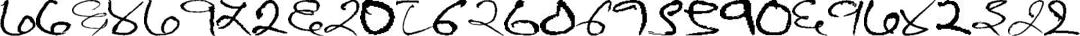

Some unprocessed vowels:


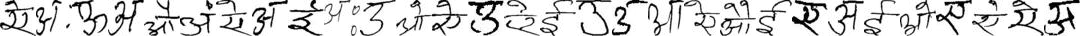

Some unprocessed consonants:


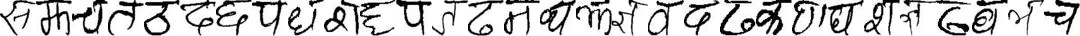

In [3]:
from IPython.display import display
from numpy import concatenate
from random import sample
from PIL import Image

def display_some(img_list, n=30, to_sample=True):
    if to_sample: 
        img_list = sample(img_list,n)
    display(Image.fromarray(concatenate(img_list,axis=1)))
    
print("Some unprocessed numerals:")
display_some(numerals_img)
print("Some unprocessed vowels:")
display_some(vowels_img)
print("Some unprocessed consonants:")
display_some(consonants_img)

### Preprocessing the images

Even if the images seems to be black and white, they are still RGB images. The first step is to convert these images to 'shades of greys' ones, reducing the dimension of the inputs from 36x36x3 to 36x36x1. A white pixel is represented by an integer value of 255, and a white one by a zero. Inverting the images, such as a stroke of the pen correpond to non-null values on the corresponding pixels usually leads to more stable results.

Some inverted numerals:


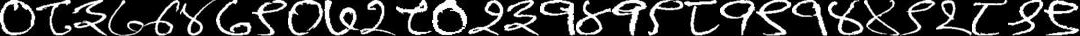

Some inverted vowels:


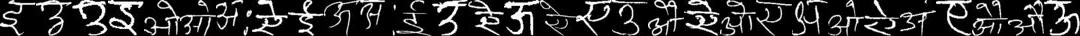

Some inverted consonants:


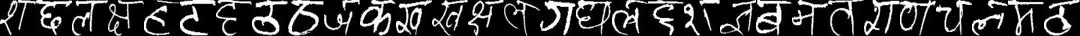

In [4]:
from PIL import ImageOps  

def pre_process(img_list):
    img_bw = [img.convert('LA') for img in img_list]
    return [ImageOps.invert(img) for img in img_list]

consonants_proc = pre_process(consonants_img)
vowels_proc = pre_process(vowels_img)
numerals_proc = pre_process(numerals_img)

print("Some inverted numerals:")
display_some(numerals_proc)
print("Some inverted vowels:")
display_some(vowels_proc)
print("Some inverted consonants:")
display_some(consonants_proc)

### Converting to tensors

In [6]:
from keras.preprocessing import image
import numpy as np

def one_img_tensor(img):
    x = image.img_to_array(img)
    # 3D tensor to 4D tensor with shape (1, nb_pixel_x, nb_pixel_y, nchannel) for stacking
    return np.expand_dims(x, axis=0)

def img_list_to_tensors(img_list):
    list_of_tensors = [one_img_tensor(img) for img in img_list]
    ref_shape = list_of_tensors[0].shape
    assert all(tens.shape == ref_shape for tens in list_of_tensors)
    return np.vstack(list_of_tensors)

tensors_numerals = img_list_to_tensors(numerals_proc).astype('float32')/255.
tensors_vowels = img_list_to_tensors(vowels_proc).astype('float32')/255.
tensors_consonants = img_list_to_tensors(consonants_proc).astype('float32')/255.

## A simple benchmark model: Support vector classifier with whitening pre-processing.

It is a good idea to train a simple classifier on our dataset, be be able to assess the performance of a more sophisticated model. Here, we choose to use a support vector machine classifier (SVC) on the reduced features returned by a principal componant analysis (PCA). The SVC is well adapted when we have few samples (no more than 10000 points, and only 200 points per class here).

These classifiers have a lot of meta-parameters, but we will tune here only the C and gamma ones. We choose to use a gaussian kernel, the default one which works usually very well. We thus define a simple function that takes a vector of inputs and a vector of labels as arguments, test several sets of parameters, and return the best SVC found.
In order to do that, we use Scikit's GridSearch that will test all combinaisons of parameters from a dictionnary, compute an accuracy with a K-Fold, and return the best model.

The principal componant analysis (also called whitening) is very useful for some image recognition problems. To see why it works, the interested reader can take a look at the `Benchmark` notebook, detailing some theoretical explanations in addition to a visual exploration of the patterns uncovered by the PCA.

First, lets define a function that will take a list of images and their labels as an input, and return the best SVC found during the parameters tuning:

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

def best_SVC(X,y):
    # Initiate a SVC classifier with default parameters
    svc_model = SVC()
    # The values to test for the C and gamma parameters.
    param_dic = {'C':[1,10,100],
                'gamma':[0.001,0.005,0.01]}
    clf = GridSearchCV(svc_model, param_dic, n_jobs=-1)
    # Search for the best set of parameters for our dataset, using bruteforce
    clf.fit(X, y)
    print("Best parameters: ", clf.best_params_)
    # We return the best model found
    return clf.best_estimator_

Then, we define another function that will take one of our three sets and its labels, and compute the accuracy of the best SVC found on a test set:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
    
def benchmark(X,y):
    
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    pca = PCA(n_components = 16)
    pca.fit(X_train)
    reduced_X_train, reduced_X_test = pca.transform(X_train), pca.transform(X_test)
    
    best_model = best_SVC(X_train,y_train)
    predictions = best_model.predict(X_test)
    return accuracy_score(y_test, predictions)

We can then compute the accuracy of our benchmark model on the three sets:

In [ ]:
score_on_numerals = benchmark(numerals_inputs, numerals_labels)
print("Best accuracy on numerals: {}".format(score_on_numerals))

score_on_vowels = benchmark(vowels_inputs, vowels_labels)
print("Best accuracy on vowels: {}".format(score_on_vowels))

score_on_consonants = benchmark(consonants_inputs, consonants_labels)
print("Best accuracy on consonants: {}".format(score_on_consonants))


On numerals, we achieve an accuracy of 97% on 10 classes. Obviously, this result is far better than random guessing, and could be a better benchmark for a more sophisticated algorithm. 
As one can expect, the model is less accurate when the number of classes is growing: only 91% on the vowels (13 classes) and 75% on the consonants (32 classes). From a human point of view, these characters also seems more complex than the numerals. As a result, a simple model like this on can perform well on character recognition if there is few classes and quite simple characters (like MNIST for instance). Otherwise, we should use a more adapted model such as CNN.

In [8]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(36,36,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(36, activation='softmax'))

model.summary()
opt = RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 34, 34, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4194560   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________

In [9]:
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint  
from keras.utils import np_utils
from sklearn.metrics import accuracy_score

def get_score_from_scratch(tensors, labels, model, epoch, batch_size, name):
    
    nb_labels = len(set(labels))
    y_all = np_utils.to_categorical([i-1 for i in np.array(labels).astype(int)], nb_labels)
    X_model, X_test, y_model, y_test = train_test_split(tensors, y_all, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, random_state=1)
    
    print("Size of the training set: {}".format(len(X_train)))
    print("Size of the validation set: {}".format(len(X_val)))
    print("Size of the testing set: {}".format(len(X_test)))

    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_{}.hdf5'.format(name), 
                               verbose=1, save_best_only=True)
    model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[checkpointer],
             batch_size=batch_size, epochs=epoch)
    model.load_weights('saved_models/weights.best.from_scratch_{}.hdf5'.format(name))
    
    y_pred = model.predict(X_test)
    print("Accuracy on test set: {}".format(
            accuracy_score(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))))
    return model

    

In [31]:
get_score_from_scratch(tensors_consonants, consonants_labels, model,50, 200,'consonants')

Size of the training set: 4151
Size of the validation set: 1384
Size of the testing set: 1845
Train on 4151 samples, validate on 1384 samples
Epoch 1/50
4151/4151 [==============================] - 1s - loss: 3.4616 - acc: 0.0797 - val_loss: 3.1501 - val_acc: 0.2717
Epoch 2/50
4151/4151 [==============================] - 1s - loss: 3.0214 - acc: 0.1857 - val_loss: 2.5199 - val_acc: 0.4082
Epoch 3/50
4151/4151 [==============================] - 1s - loss: 2.6815 - acc: 0.2645 - val_loss: 2.1532 - val_acc: 0.5094
Epoch 4/50
4151/4151 [==============================] - 1s - loss: 2.4270 - acc: 0.3202 - val_loss: 1.9103 - val_acc: 0.5650
Epoch 5/50
4151/4151 [==============================] - 1s - loss: 2.2013 - acc: 0.3842 - val_loss: 1.6484 - val_acc: 0.6337
Epoch 6/50
4151/4151 [==============================] - 1s - loss: 1.9920 - acc: 0.4230 - val_loss: 1.4451 - val_acc: 0.6467
Epoch 7/50
4151/4151 [==============================] - 1s - loss: 1.8418 - acc: 0.4659 - val_loss: 1.3022 -

### Pre-training on MNIST Database

In [37]:
from keras.datasets import mnist

(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()

X_train_mnist = X_train_mnist.reshape(X_train_mnist.shape[0], 28, 28, 1)
X_test_mnist = X_test_mnist.reshape(X_test_mnist.shape[0], 28, 28, 1)

X_train_mnist = X_train_mnist.astype('float32')/255.
X_test_mnist = X_test_mnist.astype('float32')/255.

y_train_mnist, y_test_mnist = np_utils.to_categorical(y_train_mnist),  np_utils.to_categorical(y_test_mnist)

In [22]:
model_mnist = Sequential()
model_mnist.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))
model_mnist.add(Conv2D(32, (3, 3), activation='relu'))
model_mnist.add(MaxPooling2D(pool_size=(2, 2)))
model_mnist.add(Conv2D(32, (4, 4), activation='relu'))
model_mnist.add(MaxPooling2D(pool_size=(2, 2)))
model_mnist.add(Dropout(0.25))
model_mnist.add(Flatten())
model_mnist.add(Dense(256, activation='relu'))
model_mnist.add(Dropout(0.5))
model_mnist.add(Dense(10, activation='softmax'))

model_mnist.summary()
opt = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model_mnist.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 24, 24, 32)        18464     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 9, 9, 32)          16416     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 4, 4, 32)          0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 512)               0         
__________

In [23]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.mnist.hdf5', 
                               verbose=1, save_best_only=True)
model_mnist.fit(X_train_mnist, y_train_mnist, validation_data=(X_test_mnist, y_test_mnist), callbacks=[checkpointer],
         batch_size=256, epochs=12)

model_mnist.load_weights('saved_models/weights.best.mnist.hdf5')

y_pred_mnist = model_mnist.predict(X_test_mnist)
print("Accuracy on test set: {}".format(
        accuracy_score(np.argmax(y_test_mnist,axis=1), np.argmax(y_pred_mnist,axis=1))))

Accuracy on test set: 0.9948


In [41]:
transfer_consonants = Sequential()
transfer_consonants.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(36,36,1), trainable=False))
transfer_consonants.add(Conv2D(32, (3, 3), activation='relu', trainable=False))
transfer_consonants.add(MaxPooling2D(pool_size=(2, 2)))
transfer_consonants.add(Conv2D(32, (4, 4), activation='relu', trainable=False))
transfer_consonants.add(MaxPooling2D(pool_size=(2, 2), trainable=False))
transfer_consonants.add(Dropout(0))
transfer_consonants.add(Flatten())

model_mnist.load_weights('saved_models/weights.best.mnist.hdf5')

transfer_consonants.add(Dense(256))
transfer_consonants.add(Dropout(0.5))
transfer_consonants.add(Dense(36))

transfer_consonants.summary()

opt = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
transfer_consonants.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 34, 34, 64)        640       
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 32, 32, 32)        18464     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 13, 13, 32)        16416     
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 1152)              0         
__________

In [38]:
def get_score_from_mnist(tensors, labels, model, epoch, batch_size, name):
    
    nb_labels = len(set(labels))
    y_all = np_utils.to_categorical([i-1 for i in np.array(labels).astype(int)], nb_labels)
    X_model, X_test, y_model, y_test = train_test_split(tensors, y_all, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, random_state=1)
    
    print("Size of the training set: {}".format(len(X_train)))
    print("Size of the validation set: {}".format(len(X_val)))
    print("Size of the testing set: {}".format(len(X_test)))

    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_mnist_{}.hdf5'.format(name), 
                               verbose=1, save_best_only=True)
    model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[checkpointer],
             batch_size=batch_size, epochs=epoch)
    model.load_weights('saved_models/weights.best.from_mnist_{}.hdf5'.format(name))
    
    y_pred = model.predict(X_test)
    print("Accuracy on test set: {}".format(
            accuracy_score(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))))
    return model

In [42]:
get_score_from_mnist(tensors_consonants, consonants_labels, transfer_consonants, 50, 200,'consonants')

Size of the training set: 4151
Size of the validation set: 1384
Size of the testing set: 1845
Train on 4151 samples, validate on 1384 samples
Epoch 1/50
4151/4151 [==============================] - 0s - loss: 8.2311 - acc: 0.0313 - val_loss: 7.4600 - val_acc: 0.0267
Epoch 2/50
4151/4151 [==============================] - 0s - loss: 8.1853 - acc: 0.0294 - val_loss: 8.0678 - val_acc: 0.0260
Epoch 3/50
4151/4151 [==============================] - 0s - loss: 8.3660 - acc: 0.0279 - val_loss: 7.7889 - val_acc: 0.0260
Epoch 4/50
4151/4151 [==============================] - 0s - loss: 8.3917 - acc: 0.0299 - val_loss: 7.8044 - val_acc: 0.0267
Epoch 5/50
4151/4151 [==============================] - 0s - loss: 8.2628 - acc: 0.0313 - val_loss: 8.4245 - val_acc: 0.0267
Epoch 6/50
4151/4151 [==============================] - 0s - loss: 8.2434 - acc: 0.0301 - val_loss: 8.0023 - val_acc: 0.0296
Epoch 7/50
4151/4151 [==============================] - 0s - loss: 8.2679 - acc: 0.0289 - val_loss: 7.8502 -

In [67]:
all_tensors = np.vstack((tensors_numerals, tensors_vowels, tensors_consonants))
all_labels = numerals_labels + [int(i)+10 for i in vowels_labels] + [int(i)+22 for i in consonants_labels]

nb_labels = len(set(all_labels))
all_labels = np_utils.to_categorical([i-1 for i in np.array(all_labels).astype(int)], nb_labels)
X_model, X_test, y_model, y_test = train_test_split(all_tensors, all_labels, stratify=all_labels, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, stratify=y_model, random_state=1)

In [85]:
model_for_all = Sequential()
model_for_all.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(36,36,1)))
model_for_all.add(Dropout(0.25))
model_for_all.add(Conv2D(64, (3, 3), activation='relu'))
model_for_all.add(MaxPooling2D(pool_size=(2, 2)))
model_for_all.add(Conv2D(32, (3,3), activation='relu'))
model_for_all.add(Dropout(0.25))
model_for_all.add(Flatten())
model_for_all.add(Dense(512, activation='relu'))
model_for_all.add(Dropout(0.7))
model_for_all.add(Dense(512, activation='relu'))
model_for_all.add(Dropout(0.7))
model_for_all.add(Dense(58, activation='softmax'))

model_for_all.summary()
opt = RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0)
model_for_all.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_191 (Conv2D)          (None, 34, 34, 32)        320       
_________________________________________________________________
dropout_59 (Dropout)         (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_192 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_193 (Conv2D)          (None, 14, 14, 32)        18464     
_________________________________________________________________
dropout_60 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_34 (Flatten)         (None, 6272)              0         
__________

In [81]:
print("Size of the training set: {}".format(len(X_train)))
print("Size of the validation set: {}".format(len(X_val)))
print("Size of the testing set: {}".format(len(X_test)))

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.for_all', 
                           verbose=1, save_best_only=True)
model_for_all.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[checkpointer],
         batch_size=400, epochs=100)
model_for_all.load_weights('saved_models/weights.best.for_all')

y_pred = model_for_all.predict(X_test)
print("Accuracy on test set: {}".format(
        accuracy_score(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))))

Size of the training set: 7263
Size of the validation set: 2421
Size of the testing set: 3228
Train on 7263 samples, validate on 2421 samples
Epoch 1/100
7263/7263 [==============================] - 3s - loss: 4.0371 - acc: 0.0335 - val_loss: 3.9360 - val_acc: 0.0380
Epoch 2/100
7263/7263 [==============================] - 2s - loss: 3.8417 - acc: 0.0777 - val_loss: 3.4430 - val_acc: 0.2016
Epoch 3/100
7263/7263 [==============================] - 2s - loss: 3.5148 - acc: 0.1413 - val_loss: 3.0938 - val_acc: 0.3602
Epoch 4/100
7263/7263 [==============================] - 2s - loss: 3.1969 - acc: 0.1977 - val_loss: 2.7016 - val_acc: 0.4750
Epoch 5/100
7263/7263 [==============================] - 2s - loss: 2.8835 - acc: 0.2546 - val_loss: 2.2154 - val_acc: 0.5489
Epoch 6/100
7263/7263 [==============================] - 2s - loss: 2.6730 - acc: 0.3007 - val_loss: 1.9879 - val_acc: 0.6076
Epoch 7/100
7263/7263 [==============================] - 2s - loss: 2.4220 - acc: 0.3596 - val_loss: 1

7263/7263 [==============================] - 2s - loss: 0.7337 - acc: 0.7764 - val_loss: 0.4969 - val_acc: 0.8633
Epoch 28/100
7263/7263 [==============================] - 2s - loss: 0.7028 - acc: 0.7818 - val_loss: 0.4935 - val_acc: 0.8678
Epoch 29/100
7263/7263 [==============================] - 2s - loss: 0.6819 - acc: 0.7903 - val_loss: 0.4755 - val_acc: 0.8732
Epoch 30/100
7263/7263 [==============================] - 2s - loss: 0.6480 - acc: 0.7932 - val_loss: 0.4665 - val_acc: 0.8744
Epoch 31/100
7263/7263 [==============================] - 2s - loss: 0.6364 - acc: 0.7991 - val_loss: 0.4703 - val_acc: 0.8674
Epoch 32/100
7263/7263 [==============================] - 2s - loss: 0.6127 - acc: 0.8093 - val_loss: 0.4457 - val_acc: 0.8806
Epoch 33/100
7263/7263 [==============================] - 2s - loss: 0.5745 - acc: 0.8206 - val_loss: 0.4324 - val_acc: 0.8823
Epoch 34/100
7263/7263 [==============================] - 2s - loss: 0.5542 - acc: 0.8225 - val_loss: 0.4610 - val_acc: 0.87

7263/7263 [==============================] - 2s - loss: 0.1597 - acc: 0.9488 - val_loss: 0.3952 - val_acc: 0.9058
Epoch 91/100
7263/7263 [==============================] - 2s - loss: 0.1548 - acc: 0.9518 - val_loss: 0.4103 - val_acc: 0.9083
Epoch 92/100
7263/7263 [==============================] - 2s - loss: 0.1502 - acc: 0.9496 - val_loss: 0.4041 - val_acc: 0.9095
Epoch 93/100
7263/7263 [==============================] - 2s - loss: 0.1511 - acc: 0.9532 - val_loss: 0.4125 - val_acc: 0.9071
Epoch 94/100
7263/7263 [==============================] - 2s - loss: 0.1353 - acc: 0.9561 - val_loss: 0.4152 - val_acc: 0.9083
Epoch 95/100
7263/7263 [==============================] - 2s - loss: 0.1422 - acc: 0.9525 - val_loss: 0.3871 - val_acc: 0.9124
Epoch 96/100
7263/7263 [==============================] - 2s - loss: 0.1505 - acc: 0.9521 - val_loss: 0.3933 - val_acc: 0.9091
Epoch 97/100
7263/7263 [==============================] - 2s - loss: 0.1409 - acc: 0.9553 - val_loss: 0.3849 - val_acc: 0.90

In [109]:
model_for_all = Sequential()
model_for_all.add(Conv2D(64, kernel_size=(4, 4),
                 activation='relu',
                 input_shape=(36,36,1)))
model_for_all.add(Dropout(0.25))
model_for_all.add(Conv2D(64, (3, 3), activation='relu'))
model_for_all.add(MaxPooling2D(pool_size=(2, 2)))
model_for_all.add(Conv2D(32, (3,3), activation='relu'))
model_for_all.add(Dropout(0.25))
model_for_all.add(Flatten())
model_for_all.add(Dense(512, activation='relu'))
model_for_all.add(Dropout(0.7))
model_for_all.add(Dense(512, activation='relu'))
model_for_all.add(Dropout(0.7))
model_for_all.add(Dense(58, activation='softmax'))

model_for_all.summary()
opt = RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0)
model_for_all.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_224 (Conv2D)          (None, 31, 31, 128)       4736      
_________________________________________________________________
conv2d_225 (Conv2D)          (None, 29, 29, 64)        73792     
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_226 (Conv2D)          (None, 12, 12, 32)        18464     
_________________________________________________________________
dropout_101 (Dropout)        (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_45 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_81 (Dense)             (None, 512)               2359808   
__________

In [110]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
   # width_shift_range=0.2,
   # height_shift_range=0.2,
    zoom_range=0.2)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

# fits the model on batches with real-time data augmentation:

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.for_all.datagenV1', 
                           verbose=1, save_best_only=True)

model_for_all.fit_generator(datagen.flow(X_train, y_train, batch_size=400),
                        steps_per_epoch=len(X_train) / 400, epochs=150,
                            validation_data=(X_val, y_val), callbacks=[checkpointer])

model_for_all.load_weights('saved_models/weights.best.for_all.datagenV1')

y_pred = model_for_all.predict(X_test)
print("Accuracy on test set: {}".format(
        accuracy_score(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))))


Epoch 1/150
18/18 [==============================] - 4s - loss: 3.8750 - acc: 0.0744 - val_loss: 3.2270 - val_acc: 0.2916
Epoch 2/150
18/18 [==============================] - 2s - loss: 3.3170 - acc: 0.1877 - val_loss: 2.6417 - val_acc: 0.4477
Epoch 3/150
18/18 [==============================] - 2s - loss: 2.9616 - acc: 0.2590 - val_loss: 2.2825 - val_acc: 0.4919
Epoch 4/150
18/18 [==============================] - 2s - loss: 2.7619 - acc: 0.3020 - val_loss: 1.9810 - val_acc: 0.5791
Epoch 5/150
18/18 [==============================] - 2s - loss: 2.5859 - acc: 0.3366 - val_loss: 1.8016 - val_acc: 0.6088
Epoch 6/150
18/18 [==============================] - 2s - loss: 2.3956 - acc: 0.3791 - val_loss: 1.6031 - val_acc: 0.6357
Epoch 7/150
18/18 [==============================] - 2s - loss: 2.3112 - acc: 0.3906 - val_loss: 1.4922 - val_acc: 0.6448
Epoch 8/150
18/18 [==============================] - 2s - loss: 2.1462 - acc: 0.4278 - val_loss: 1.4254 - val_acc: 0.6679
Epoch 9/150
18/18 [=====

18/18 [==============================] - 2s - loss: 1.1197 - acc: 0.6670 - val_loss: 0.5520 - val_acc: 0.8612
Epoch 28/150
18/18 [==============================] - 2s - loss: 1.0683 - acc: 0.6850 - val_loss: 0.5575 - val_acc: 0.8612
Epoch 29/150
18/18 [==============================] - 2s - loss: 1.0524 - acc: 0.6958 - val_loss: 0.5392 - val_acc: 0.8670
Epoch 30/150
18/18 [==============================] - 2s - loss: 0.9883 - acc: 0.7066 - val_loss: 0.5336 - val_acc: 0.8583
Epoch 31/150
18/18 [==============================] - 2s - loss: 1.0268 - acc: 0.6951 - val_loss: 0.5095 - val_acc: 0.8670
Epoch 32/150
18/18 [==============================] - 2s - loss: 0.9778 - acc: 0.7089 - val_loss: 0.5010 - val_acc: 0.8703
Epoch 33/150
18/18 [==============================] - 2s - loss: 0.9397 - acc: 0.7180 - val_loss: 0.4841 - val_acc: 0.8761
Epoch 34/150
18/18 [==============================] - 2s - loss: 0.9569 - acc: 0.7230 - val_loss: 0.5009 - val_acc: 0.8686
Epoch 35/150
18/18 [=========

18/18 [==============================] - 2s - loss: 0.4498 - acc: 0.8556 - val_loss: 0.2835 - val_acc: 0.9269
Epoch 86/150
18/18 [==============================] - 2s - loss: 0.4590 - acc: 0.8599 - val_loss: 0.3082 - val_acc: 0.9133
Epoch 87/150
18/18 [==============================] - 2s - loss: 0.4622 - acc: 0.8501 - val_loss: 0.2925 - val_acc: 0.9219
Epoch 88/150
18/18 [==============================] - 2s - loss: 0.4308 - acc: 0.8621 - val_loss: 0.2783 - val_acc: 0.9265
Epoch 89/150
18/18 [==============================] - 2s - loss: 0.4658 - acc: 0.8551 - val_loss: 0.2783 - val_acc: 0.9281
Epoch 90/150
18/18 [==============================] - 2s - loss: 0.4257 - acc: 0.8664 - val_loss: 0.2880 - val_acc: 0.9207
Epoch 91/150
18/18 [==============================] - 2s - loss: 0.4352 - acc: 0.8626 - val_loss: 0.2994 - val_acc: 0.9186
Epoch 92/150
18/18 [==============================] - 2s - loss: 0.4299 - acc: 0.8645 - val_loss: 0.2689 - val_acc: 0.9285
Epoch 93/150
18/18 [=========

18/18 [==============================] - 2s - loss: 0.2568 - acc: 0.9166 - val_loss: 0.2418 - val_acc: 0.9409
Epoch 149/150
18/18 [==============================] - 2s - loss: 0.2604 - acc: 0.9139 - val_loss: 0.2476 - val_acc: 0.9389
Epoch 150/150
18/18 [==============================] - 2s - loss: 0.2666 - acc: 0.9122 - val_loss: 0.2434 - val_acc: 0.9352
Accuracy on test set: 0.934324659232
